In [6]:
!pip install vaderSentiment

In [1]:
import pandas as pd
import re 
import nltk as nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import time
import math
import string
import gensim
import pyLDAvis
import os
import requests
import pprint
import seaborn as sns 
import matplotlib.pyplot as plt
#import pyLDAvis.gensim
#import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.simplefilter('ignore')

from IPython.display import clear_output
from wordcloud import WordCloud
from joblib import dump, load
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pyLDAvis.enable_notebook()
#nlp = spacy.load("en_core_web_sm")

In [2]:
import pandarallel
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()

pandarallel.initialize(nb_workers=num_processors, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### **Sentiment Analysis using VADER**

In [3]:
analyzer = SentimentIntensityAnalyzer()

def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{} {}".format(sentence, sent))

In [4]:
%%time

df = pd.read_parquet('df_sentiment.parquet', engine='pyarrow')
df.shape

CPU times: user 17.5 s, sys: 2.91 s, total: 20.5 s
Wall time: 16.8 s


(170984, 10)

In [5]:
df.sample(2, random_state = 42)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,clean_text_tokens,sentiment
84444,2021-03-30,2021,3,30,1,Cambridge Quantum Computing Pioneers Quantum M...,Cambridge Quantum Computing Pioneers Quantum M...,"[cambridge, quantum, computing, pioneers, quan...","[cambridge, quantum, computing, pioneers, quan...",1
35622,2022-12-08,2022,12,8,3,Aetina Launches New ASICBased Edge AI System P...,Aetina Launches New ASICBased Edge AI System P...,"[aetina, launches, new, asicbased, edge, ai, s...","[aetina, launches, new, asicbased, edge, ai, s...",1


In [6]:
df.rename(columns={'sentiment': 'initial_sent'}, inplace=True)


In [7]:
df.sample(2, random_state = 42)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,clean_text_tokens,initial_sent
84444,2021-03-30,2021,3,30,1,Cambridge Quantum Computing Pioneers Quantum M...,Cambridge Quantum Computing Pioneers Quantum M...,"[cambridge, quantum, computing, pioneers, quan...","[cambridge, quantum, computing, pioneers, quan...",1
35622,2022-12-08,2022,12,8,3,Aetina Launches New ASICBased Edge AI System P...,Aetina Launches New ASICBased Edge AI System P...,"[aetina, launches, new, asicbased, edge, ai, s...","[aetina, launches, new, asicbased, edge, ai, s...",1


In [8]:
%time df["sentiment_score"] = df["clean_text"].parallel_apply(lambda x : analyzer.polarity_scores(x)["compound"])

CPU times: user 1min 3s, sys: 15.1 s, total: 1min 19s
Wall time: 5min 4s


In [9]:
df['sentiment'] = np.where(df['sentiment_score'].astype(np.float) > 0, 'Positive', 'Negative')
df['sentiment'] = np.where(df['sentiment_score'].astype(np.float) == 0, 'Neutral', df['sentiment'])

In [13]:
df.sample(2, random_state = 42)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,clean_text_tokens,initial_sent,sentiment_score,sentiment
84444,2021-03-30,2021,3,30,1,Cambridge Quantum Computing Pioneers Quantum M...,Cambridge Quantum Computing Pioneers Quantum M...,"[cambridge, quantum, computing, pioneers, quan...","[cambridge, quantum, computing, pioneers, quan...",1,0.9323,Positive
35622,2022-12-08,2022,12,8,3,Aetina Launches New ASICBased Edge AI System P...,Aetina Launches New ASICBased Edge AI System P...,"[aetina, launches, new, asicbased, edge, ai, s...","[aetina, launches, new, asicbased, edge, ai, s...",1,0.9944,Positive


In [14]:
df["initial_sent"].value_counts()

0    101981
1     69003
Name: initial_sent, dtype: int64

In [15]:
# Vader provides lesser no. of negative sentiment
df["sentiment"].value_counts()

Positive    158890
Negative     12085
Neutral          9
Name: sentiment, dtype: int64

In [16]:
df.to_parquet('df_sentiment.parquet')

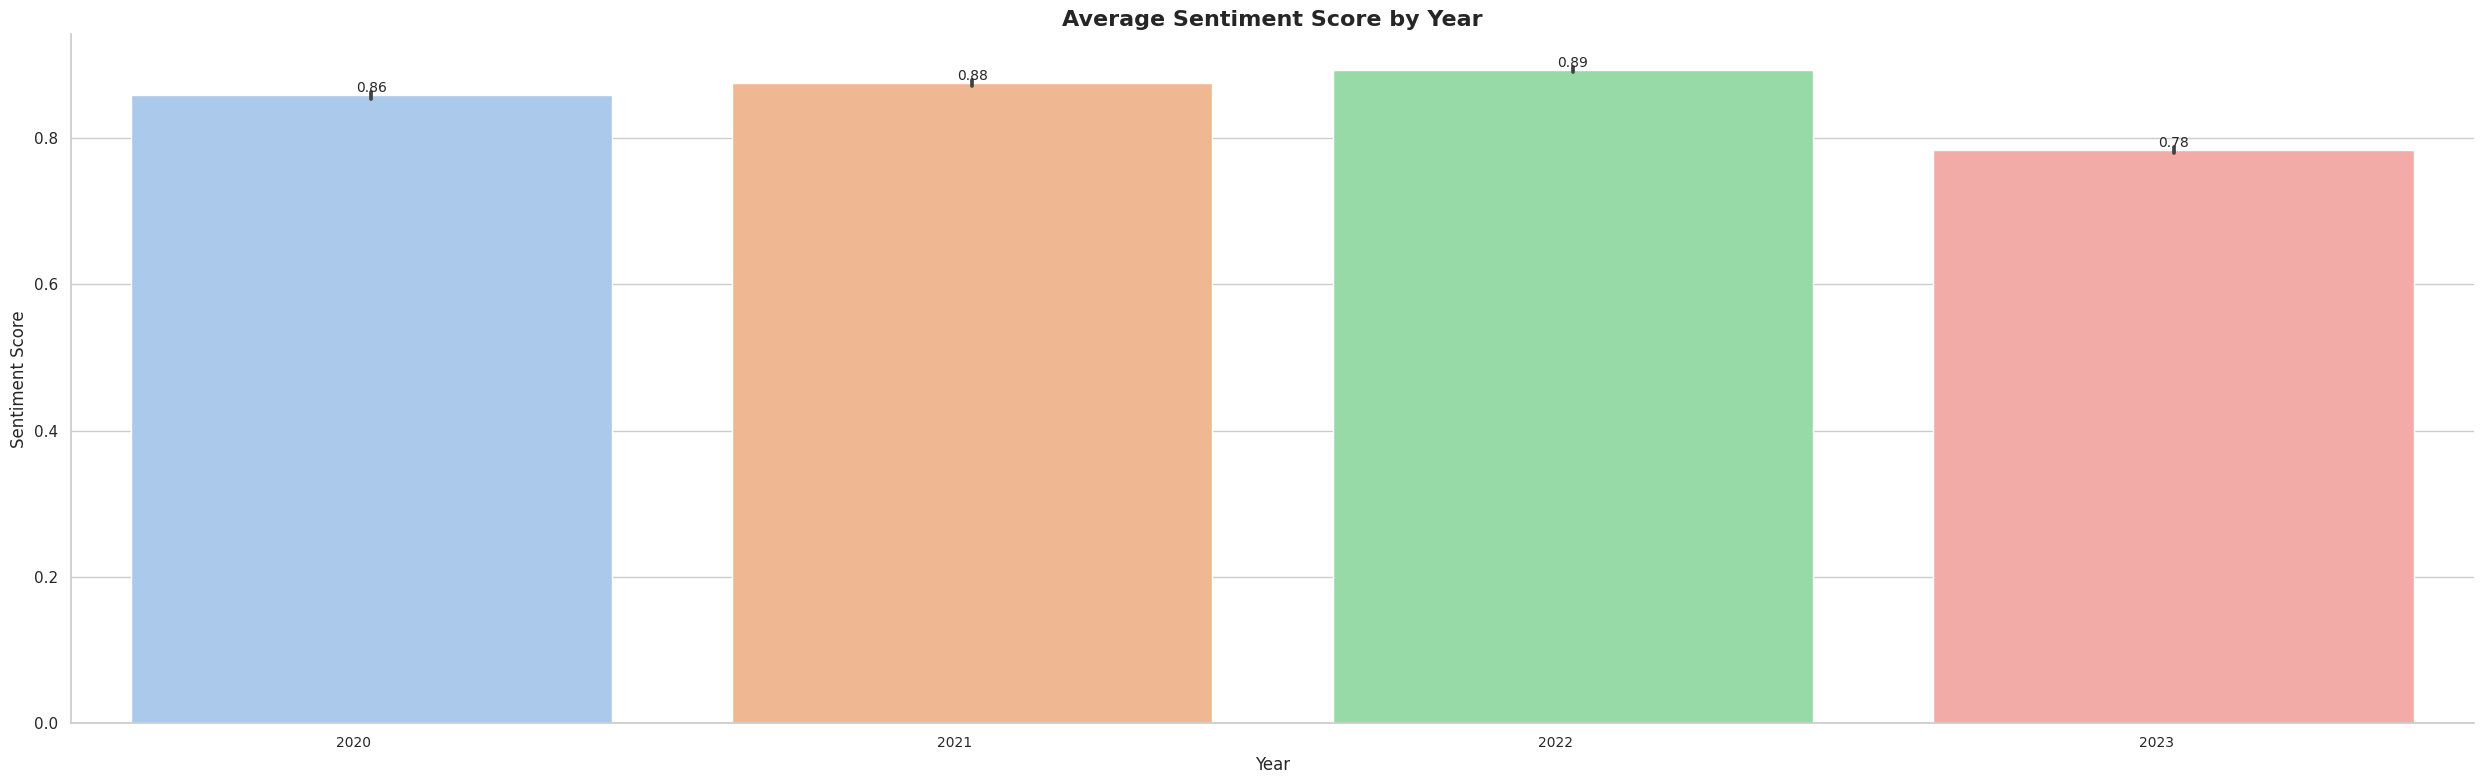

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
colors = sns.color_palette("pastel", len(df["year"].unique()))

# Create the bar plot with the custom color palette
ax = sns.barplot(x="year", y="sentiment_score", data=df, palette=colors)

# Set the title, x-axis label, and y-axis label
plt.title("Average Sentiment Score by Year", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)

# Customize the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=10)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Add a horizontal grid
ax.yaxis.grid(True)

# Remove the top and right spines
sns.despine()

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


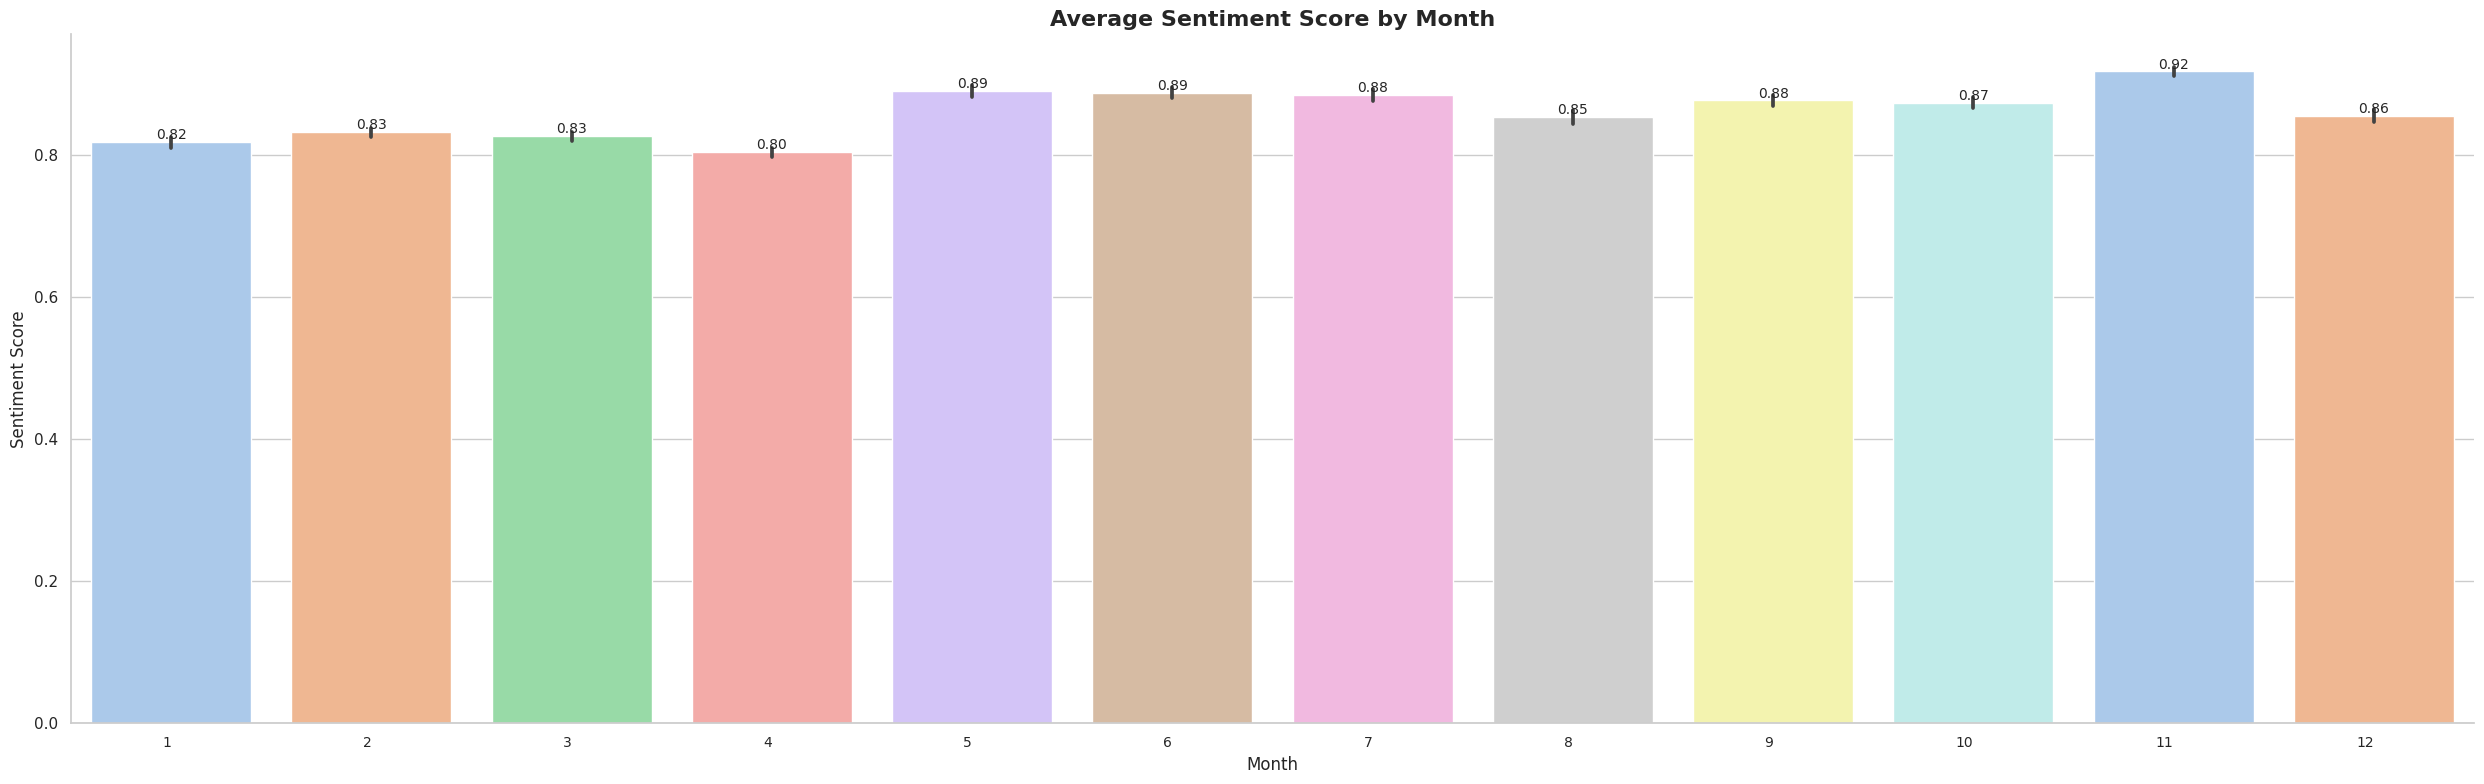

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
colors = sns.color_palette("pastel", len(df["month"].unique()))

# Create the bar plot with the custom color palette
ax = sns.barplot(x="month", y="sentiment_score", data=df, palette=colors)

# Set the title, x-axis label, and y-axis label
plt.title("Average Sentiment Score by Month", fontsize=16, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)

# Customize the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=10)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Add a horizontal grid
ax.yaxis.grid(True)

# Remove the top and right spines
sns.despine()

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


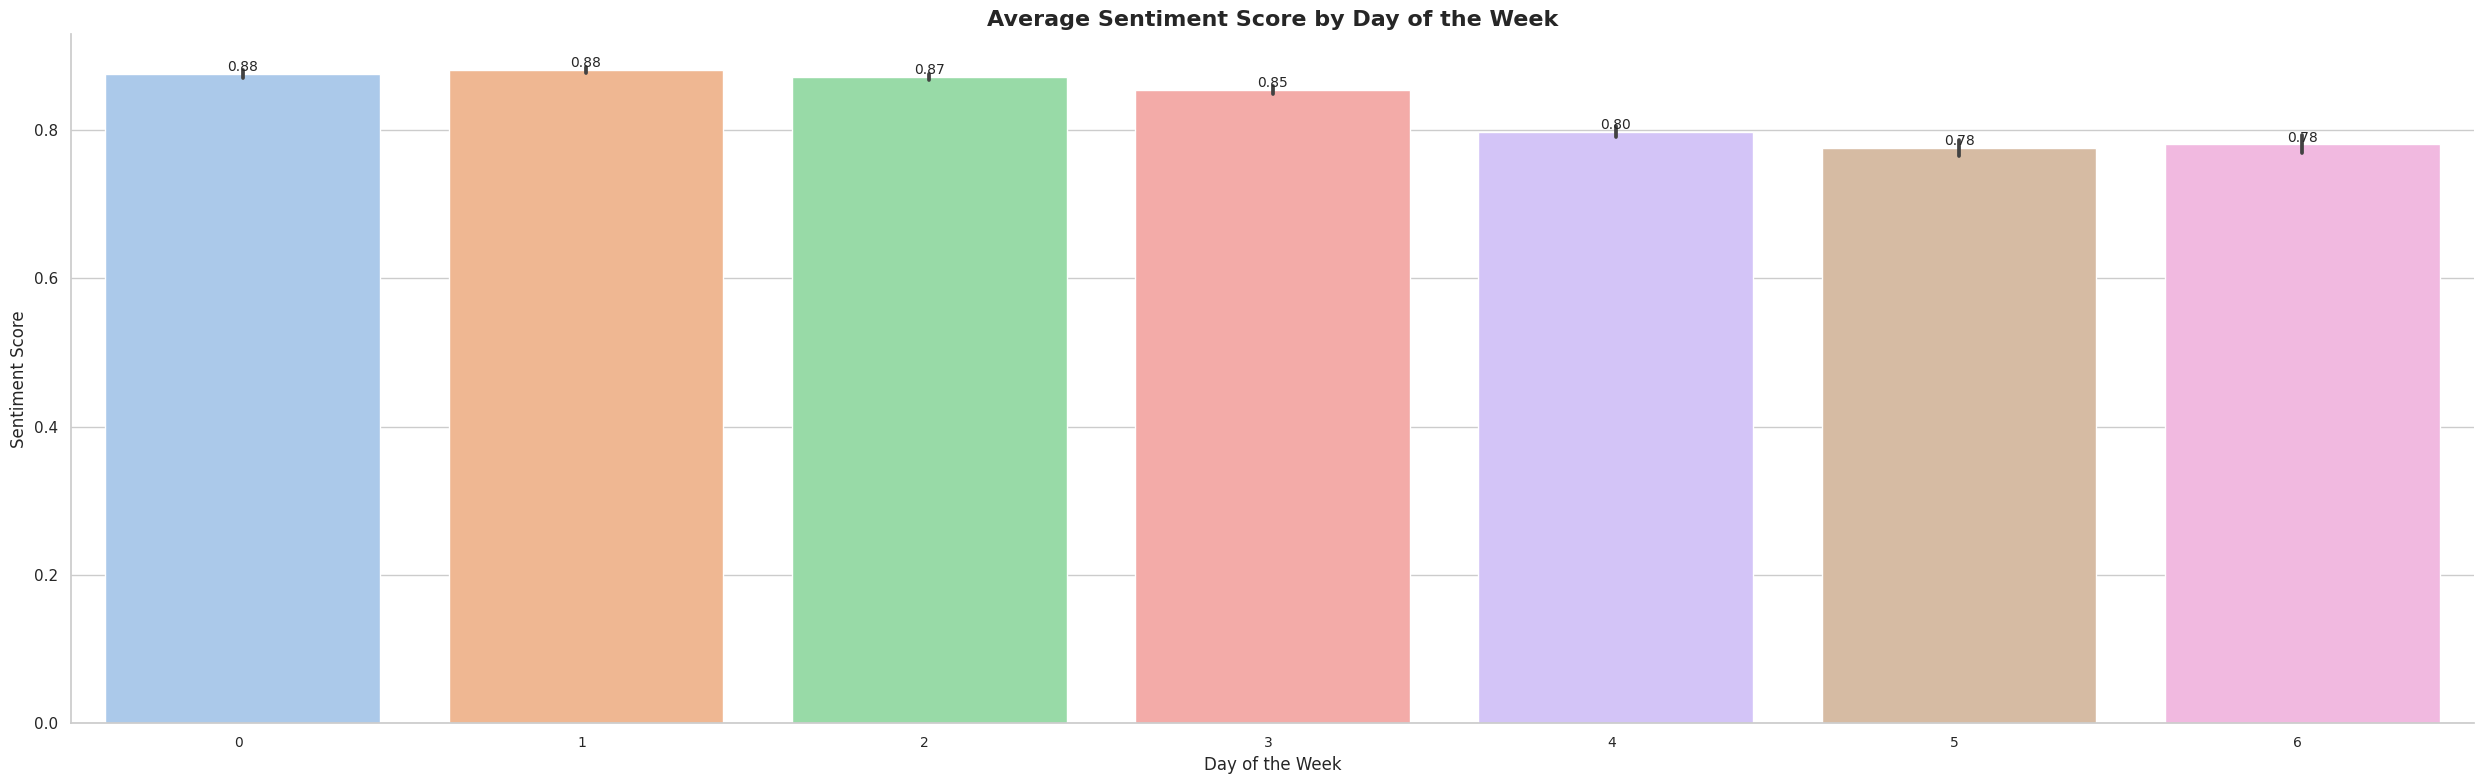

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
colors = sns.color_palette("pastel", len(df["dayofweek"].unique()))

# Create the bar plot with the custom color palette
ax = sns.barplot(x="dayofweek", y="sentiment_score", data=df, palette=colors)

# Set the title, x-axis label, and y-axis label
plt.title("Average Sentiment Score by Day of the Week", fontsize=16, fontweight="bold")
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)

# Customize the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=10)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Add a horizontal grid
ax.yaxis.grid(True)

# Remove the top and right spines
sns.despine()

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


In [42]:
pos_text_corpus = ' '.join(df['clean_text'][df["sentiment"]=="Positive"].values)
neg_text_corpus = ' '.join(df['clean_text'][df["sentiment"]=="Negative"].values)

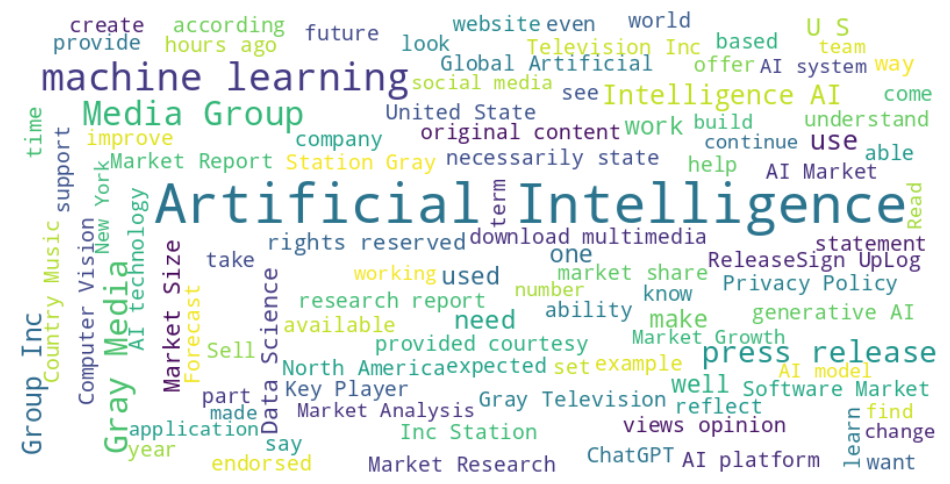

In [43]:
pos_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(pos_text_corpus)
plt.figure(figsize=(12, 8))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

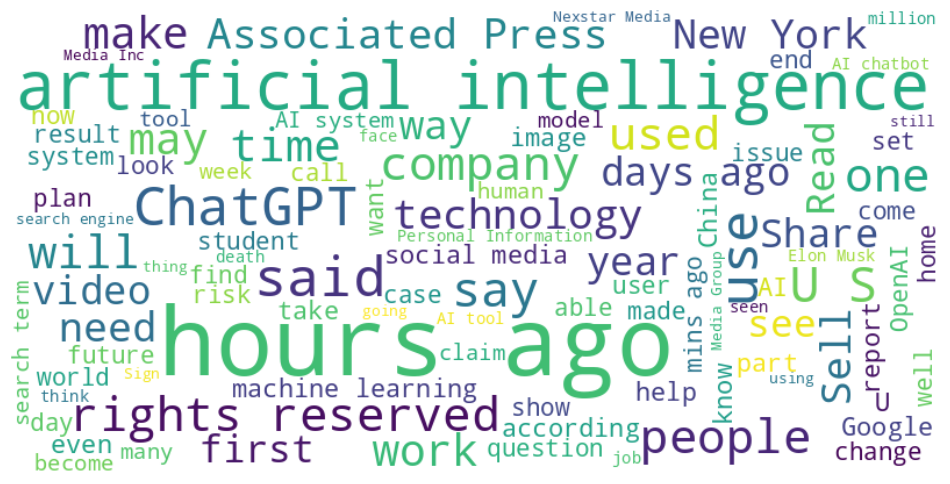

In [44]:
neg_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(neg_text_corpus)
plt.figure(figsize=(12, 8))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
df_pos = df[df["sentiment"]=="Positive"]
df_neg = df[df["sentiment"]=="Negative"]

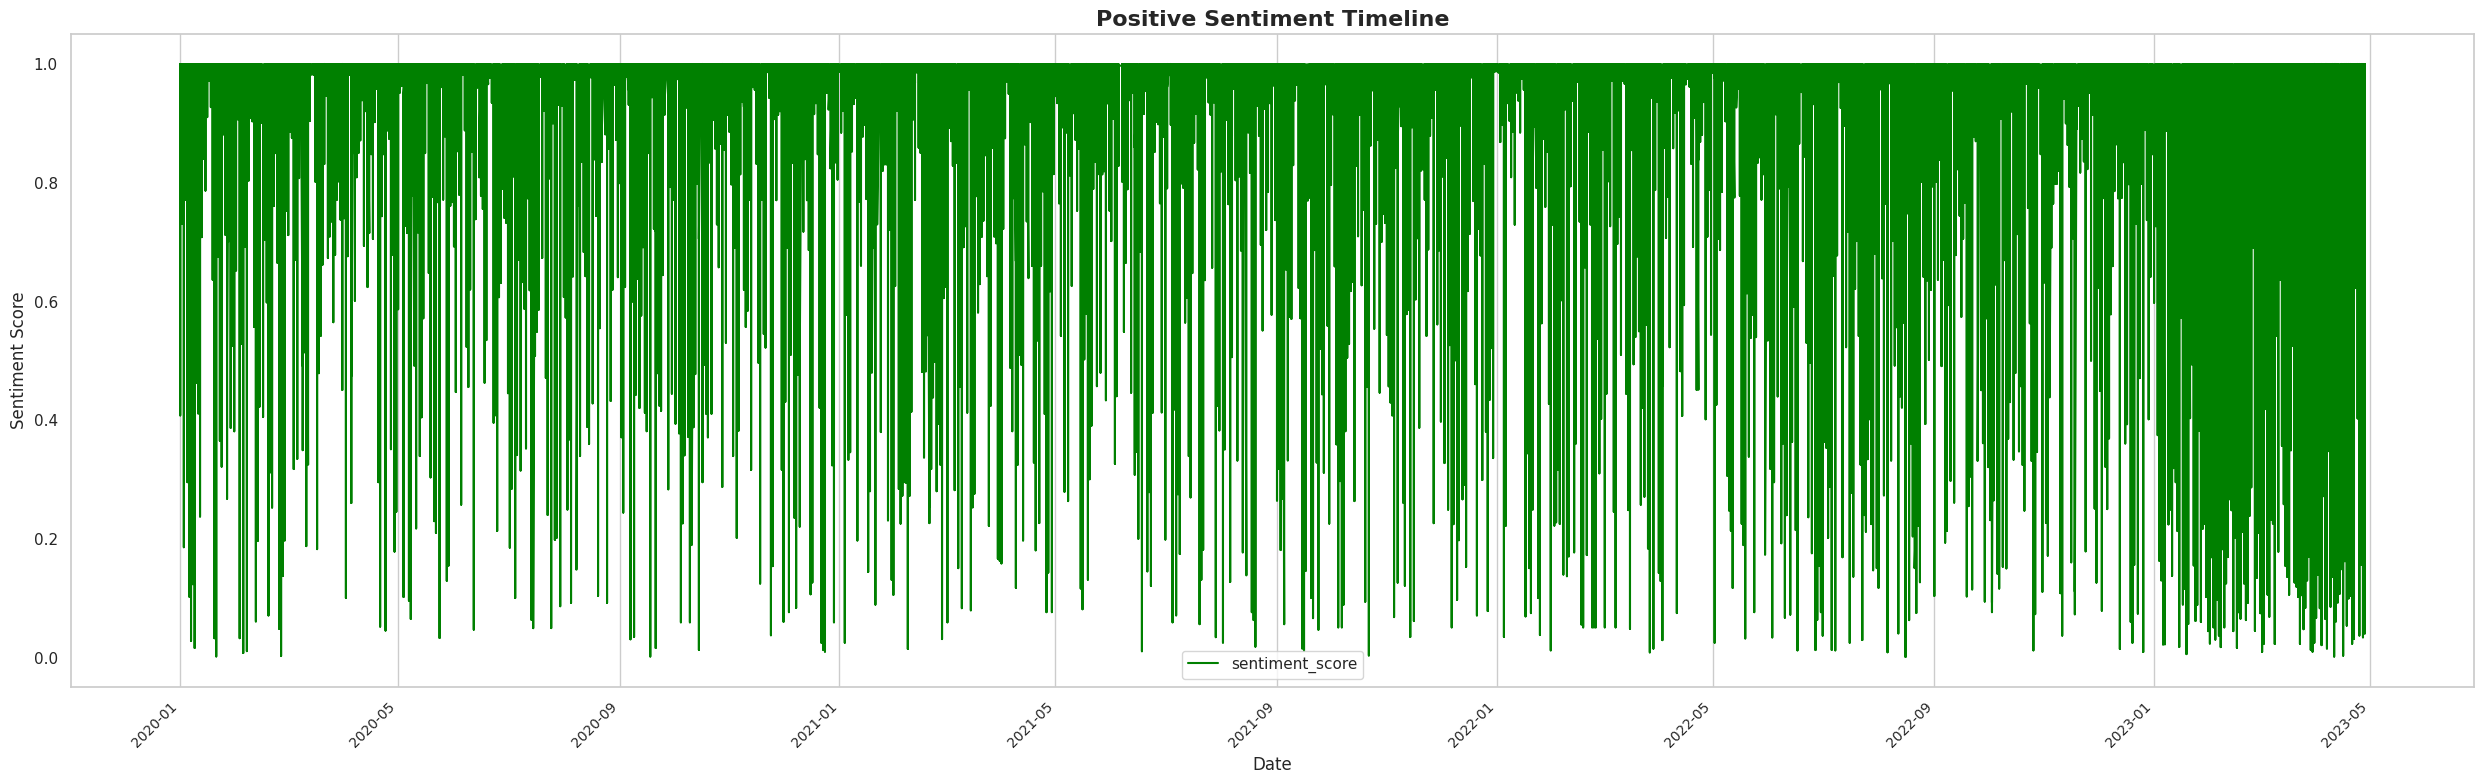

In [69]:
# Set the figure size
plt.rcParams["figure.figsize"] = (25, 8)

# Create the timeline plot
timeline_df = df_pos[['date', 'sentiment_score']].set_index('date')
ax = timeline_df.plot(color='green')

# Set the title
plt.title('Positive Sentiment Timeline', fontsize=16, fontweight='bold')

# Set the x-axis label
plt.xlabel('Date', fontsize=12)

# Set the y-axis label
plt.ylabel('Sentiment Score', fontsize=12)

# Add a horizontal grid
plt.grid(axis='y')

# Customize the tick labels on the x-axis
plt.xticks(fontsize=10, rotation=45, ha='right')

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


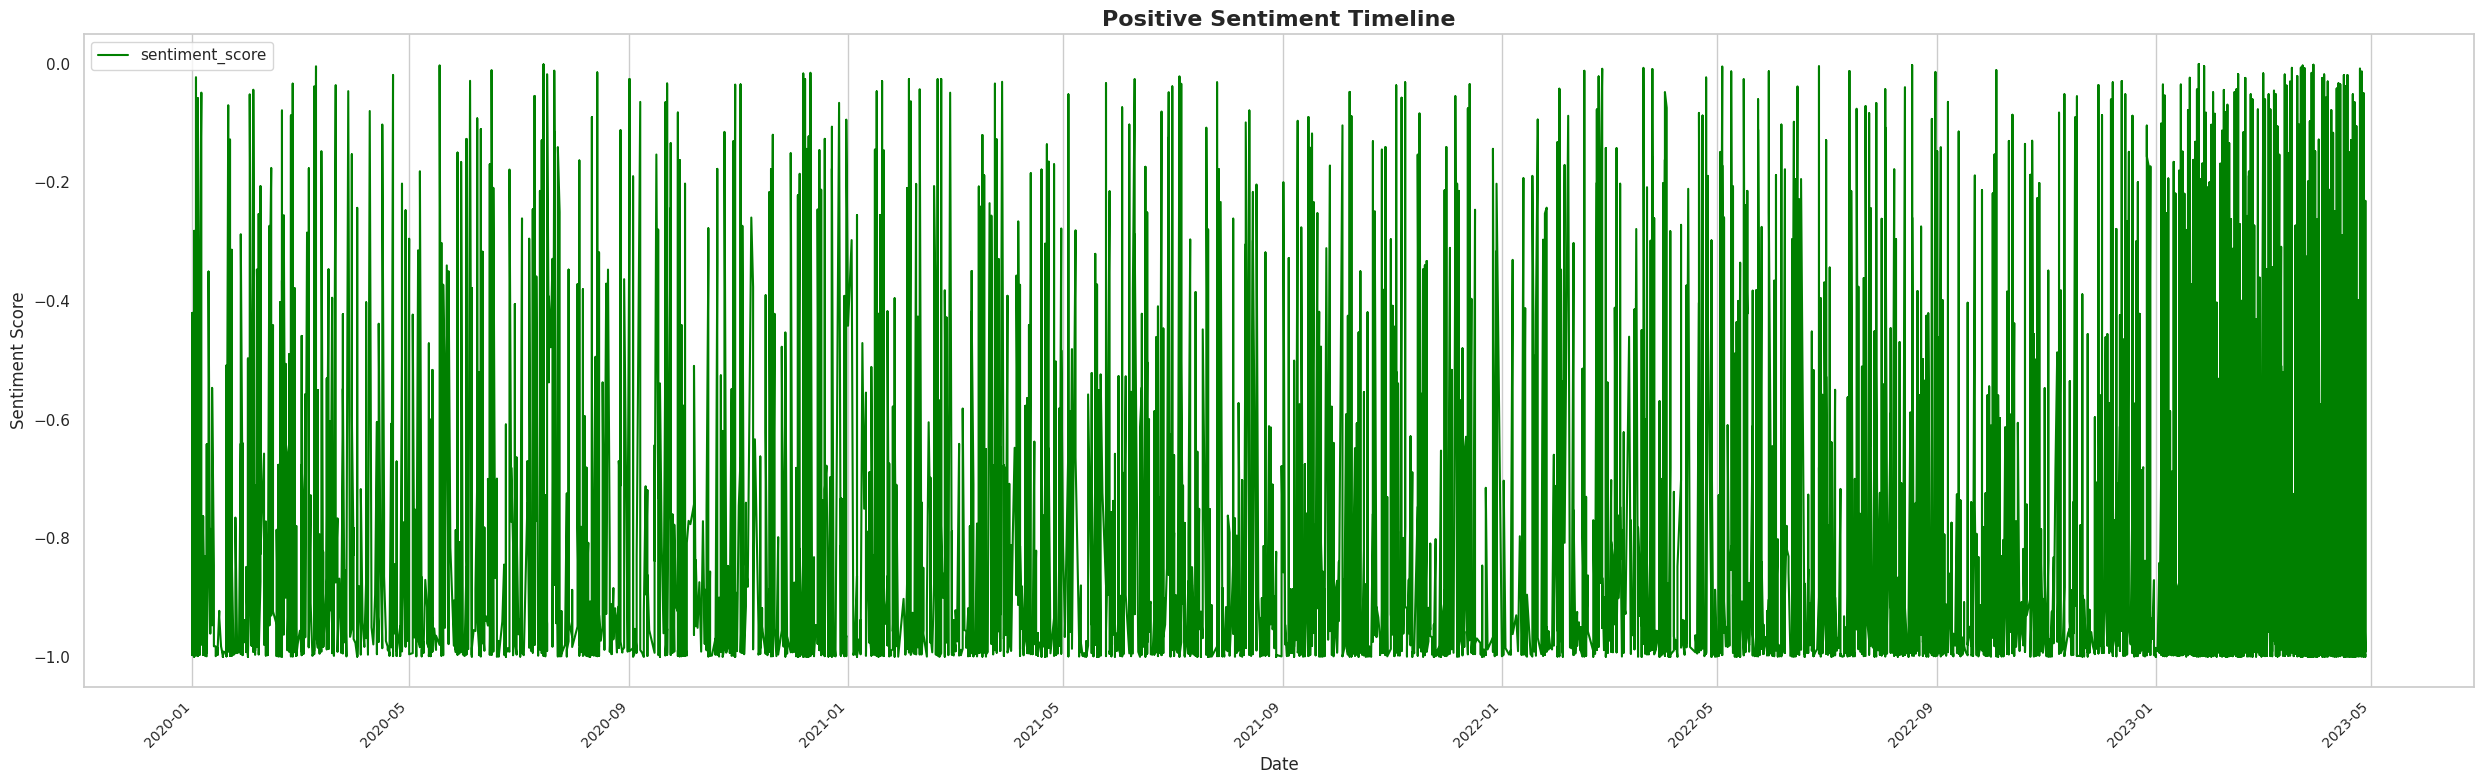

In [70]:
# Set the figure size
plt.rcParams["figure.figsize"] = (25, 8)

# Create the timeline plot
timeline_df = df_neg[['date', 'sentiment_score']].set_index('date')
ax = timeline_df.plot(color='green')

# Set the title
plt.title('Positive Sentiment Timeline', fontsize=16, fontweight='bold')

# Set the x-axis label
plt.xlabel('Date', fontsize=12)

# Set the y-axis label
plt.ylabel('Sentiment Score', fontsize=12)

# Add a horizontal grid
plt.grid(axis='y')

# Customize the tick labels on the x-axis
plt.xticks(fontsize=10, rotation=45, ha='right')

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


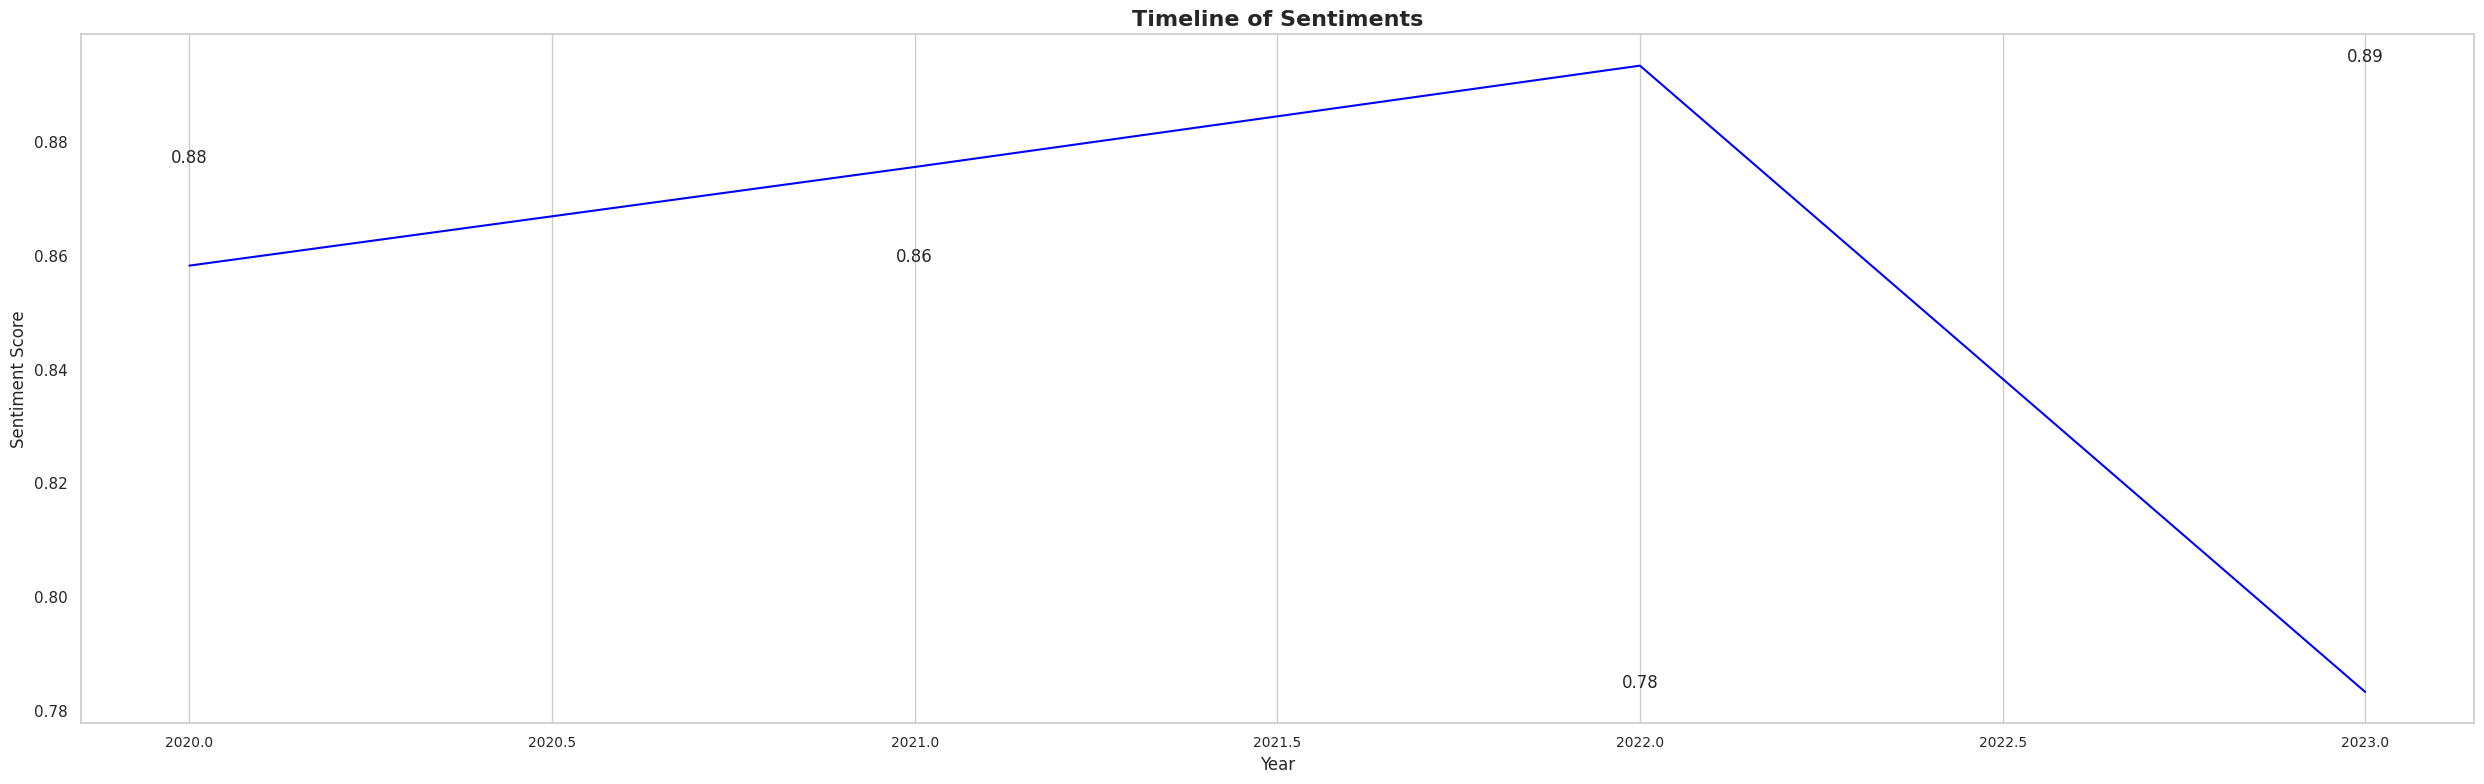

In [75]:
# Create the groupby plot
sns.set_style("whitegrid")
ax = df.groupby(["year"])["sentiment_score"].mean().plot(color='blue')

# Set the title
plt.title("Timeline of Sentiments", fontsize=16, fontweight='bold')

# Set the x-axis label
plt.xlabel("Year", fontsize=12)

# Set the y-axis label
plt.ylabel("Sentiment Score", fontsize=12)

# Customize the tick labels on the x-axis
plt.xticks(fontsize=10)

# Add a horizontal grid
plt.grid(axis='y')

# Add data labels to the line plot
for x, y in zip(df["year"].unique(), df.groupby(["year"])["sentiment_score"].mean()):
    plt.text(x, y, format(y, '.2f'), ha='center', va='bottom')

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


Text(0, 0.5, 'Sentiment_Score')

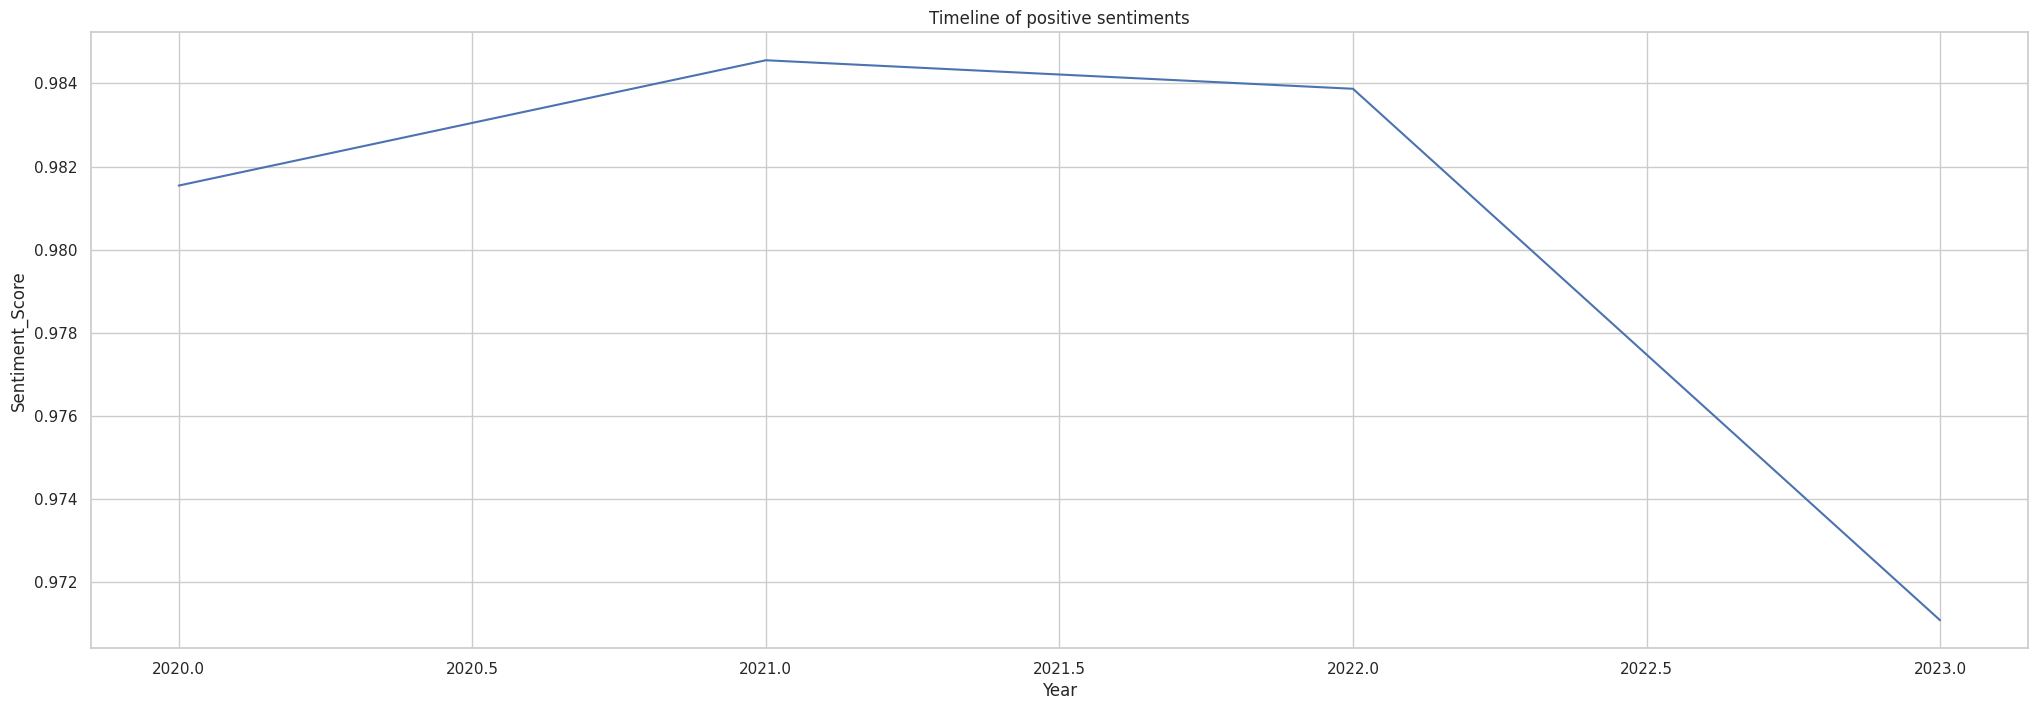

In [78]:
df_pos.groupby(["year"])["sentiment_score"].mean().plot()
plt.title("Timeline of positive sentiments")
plt.xlabel("Year")
plt.ylabel("Sentiment_Score")

Text(0, 0.5, 'Sentiment_Score')

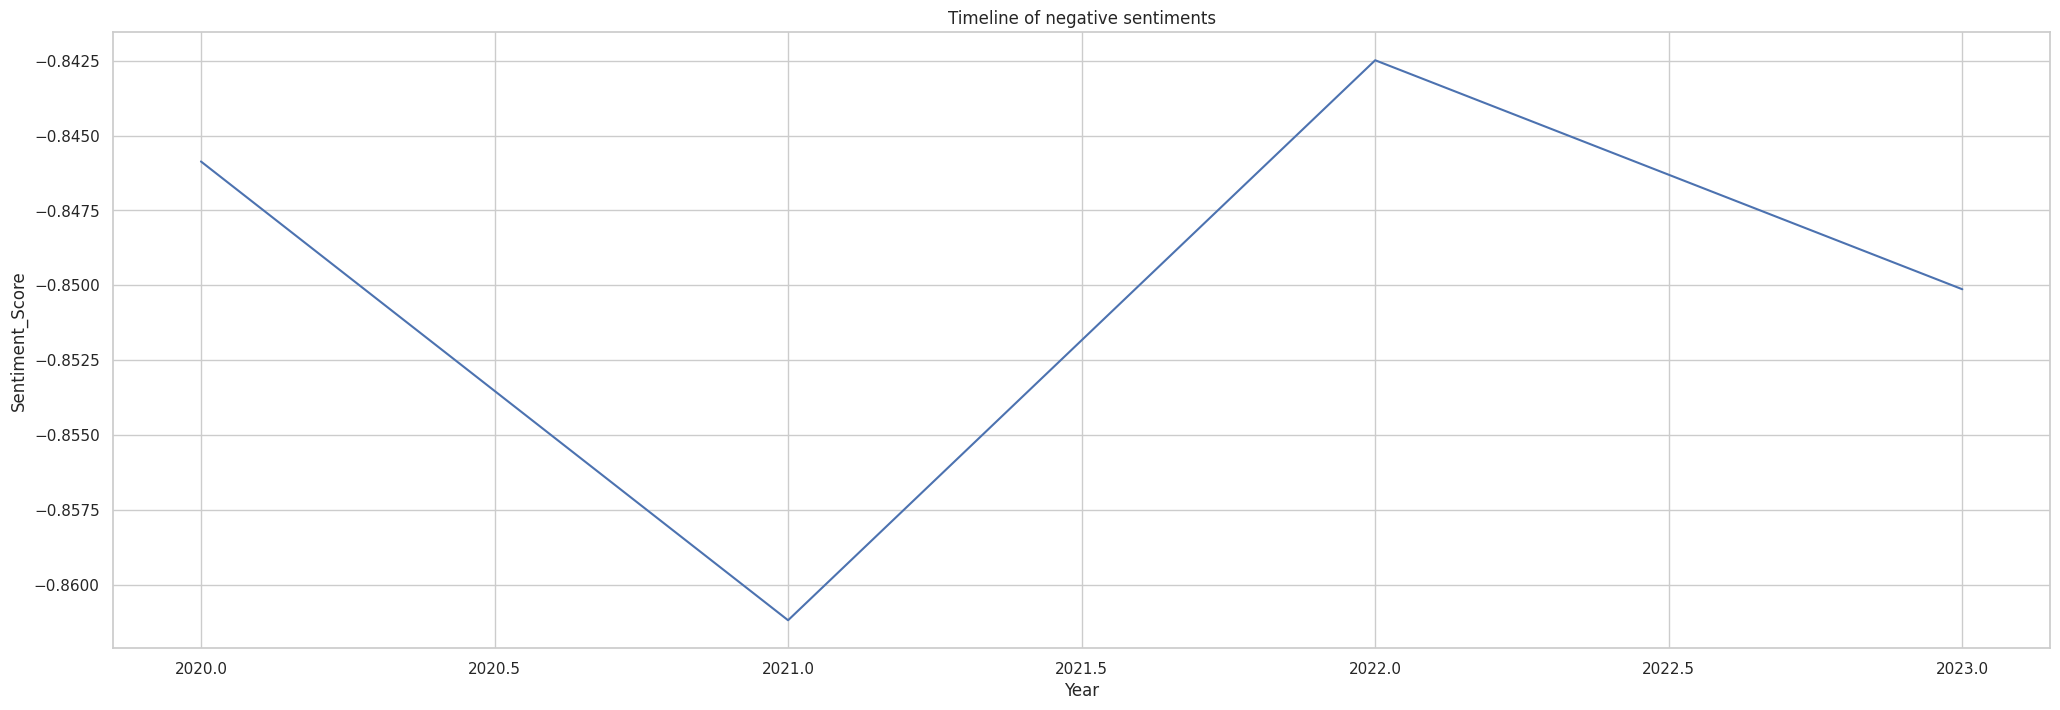

In [79]:
df_neg.groupby(["year"])["sentiment_score"].mean().plot()
plt.title("Timeline of negative sentiments")
plt.xlabel("Year")
plt.ylabel("Sentiment_Score")

In [80]:
df_neg_max = df_neg[df_neg["sentiment_score"]<-0.95]
df_pos_max = df_pos[df_pos["sentiment_score"]>0.85]

Text(0, 0.5, 'Sentiment_Score')

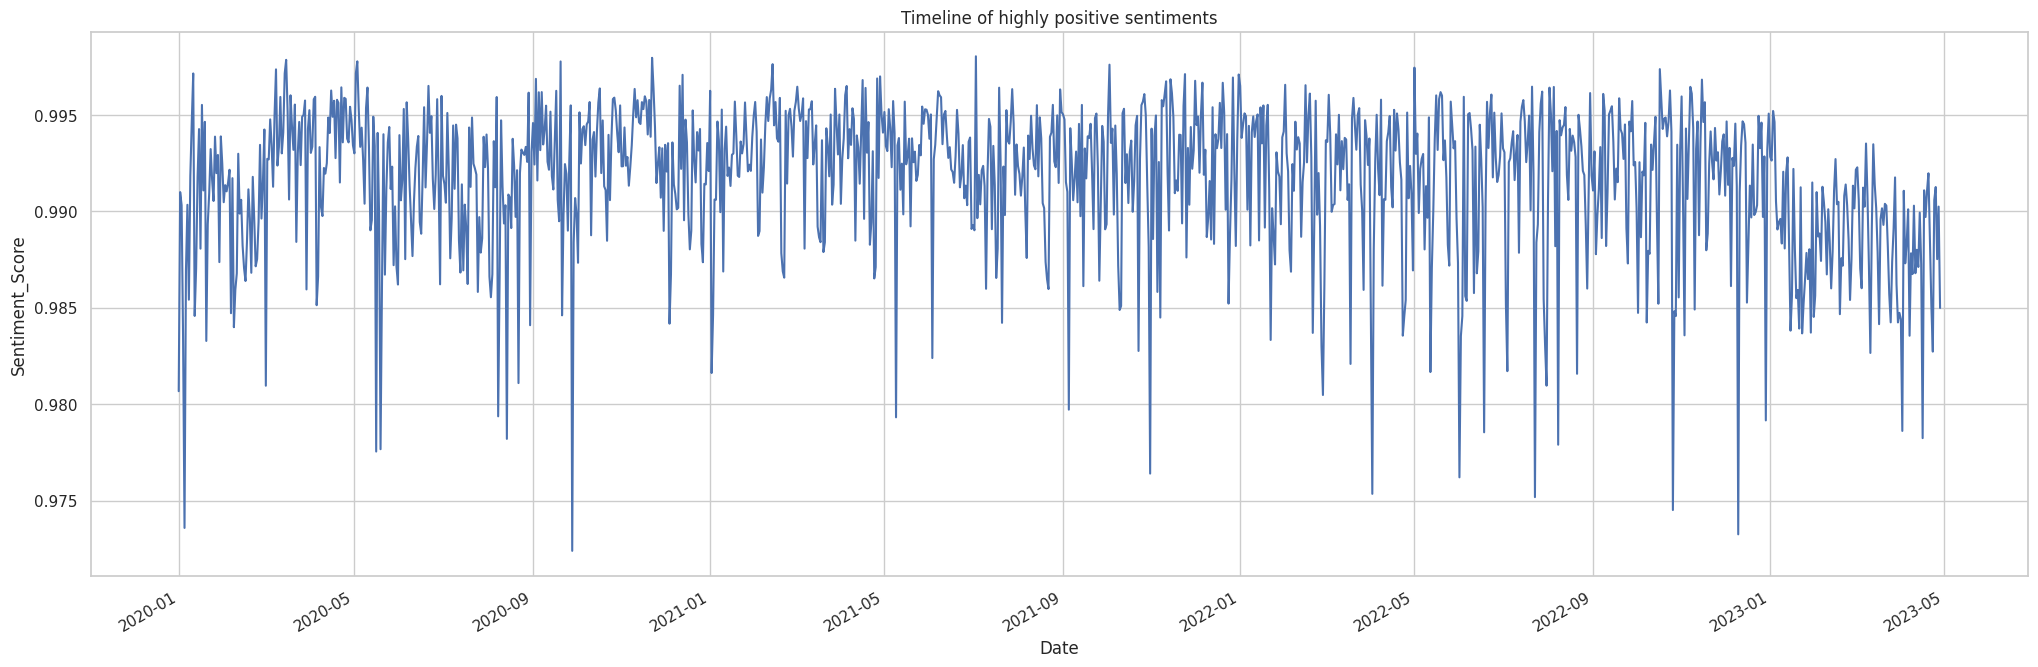

In [81]:
df_pos_max.groupby(["date"])["sentiment_score"].mean().plot()
plt.title("Timeline of highly positive sentiments")
plt.xlabel("Date")
plt.ylabel("Sentiment_Score")

Text(0, 0.5, 'Sentiment_Score')

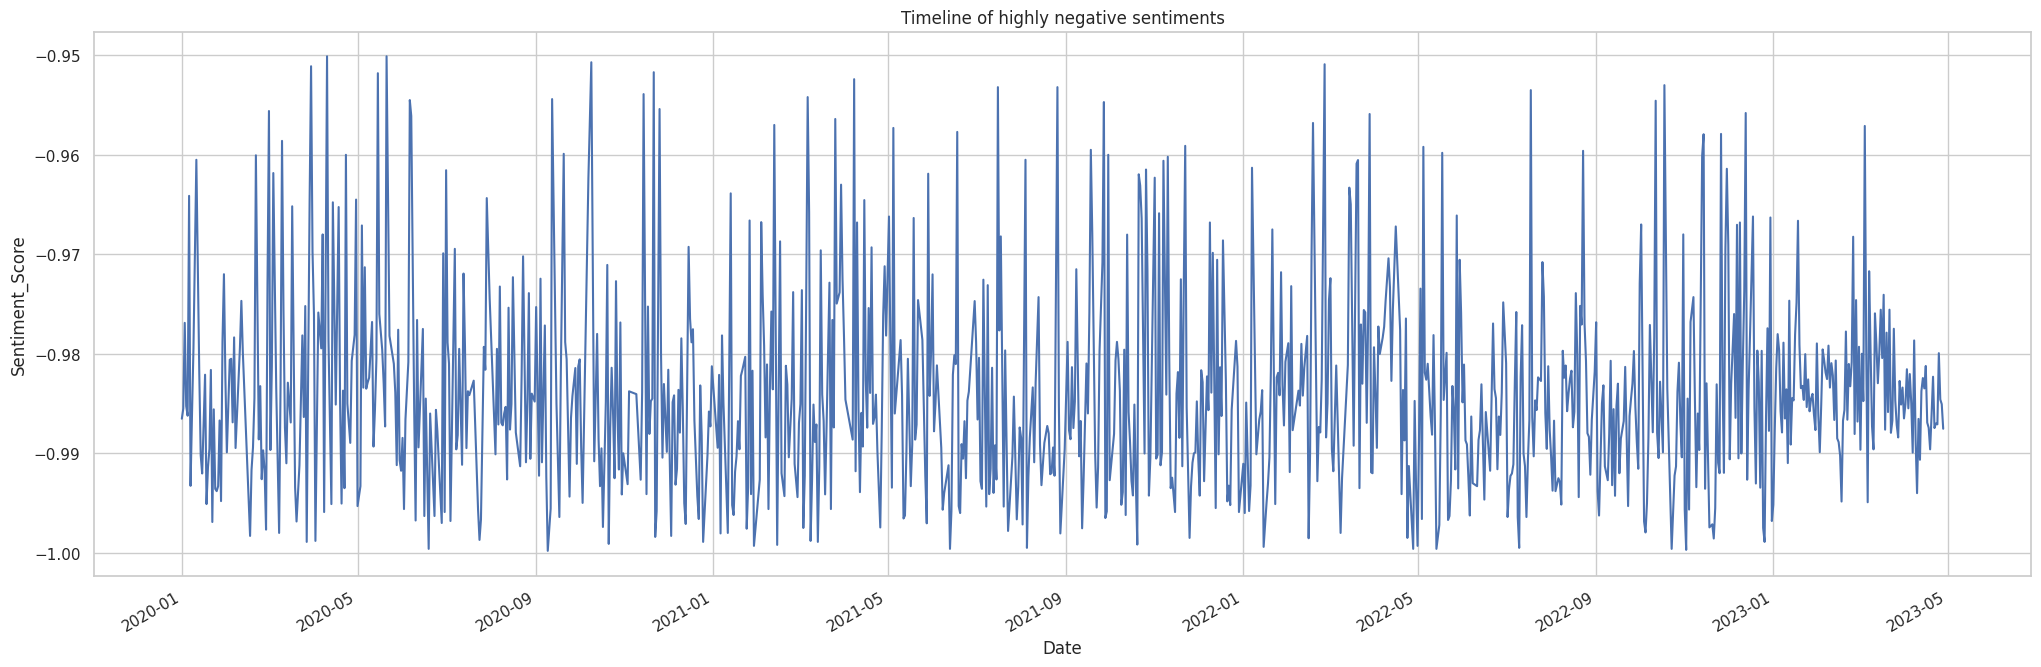

In [82]:
df_neg_max.groupby(["date"])["sentiment_score"].mean().plot()
plt.title("Timeline of highly negative sentiments")
plt.xlabel("Date")
plt.ylabel("Sentiment_Score")